# A test example with known drift and diffusion

First run the example to train and save the trained model
```shell
cd ./examples/test_case
python test_case.py
```

The results will be saved to a path in `./outputs/...` that appropriately time-stamped.

The rest of the notebook will perform checking analysis on the outputs.

In [1]:
import jax
import os
import equinox as eqx
from test_case import build_model, build_targets
from omegaconf import OmegaConf

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

## Load saved model and configs

In [9]:
path = "outputs/2024_09_15-13_39_42"

In [10]:
config = OmegaConf.load(os.path.join(path, ".hydra", "config.yaml"))
model = build_model(config=config)
model = eqx.tree_deserialise_leaves(os.path.join(path, "model.eqx"), model)
target_model = build_targets(config=config)

## Visualise the learned and true potential

We now visualise the learned vs the true potential functions.
Note that $V$ is only determined up to a constant, so we will set 
$$
    V(z) \mapsto V(z) - \min_{z'} V(z')
$$

Text(0.5, 1.0, 'Learned Potential')

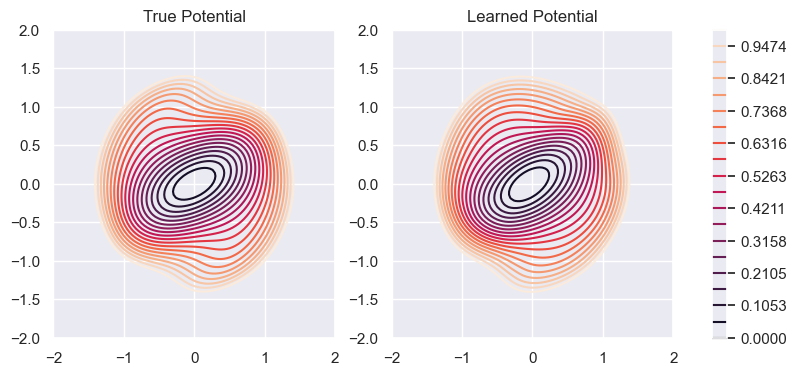

In [11]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
XY = np.stack([X, Y], axis=-1).reshape(-1, 2)
Z_true = jax.vmap(target_model.potential, in_axes=(0, None))(XY, [config.temperature]).reshape(100, 100)
Z_pred = jax.vmap(model.potential, in_axes=(0, None))(XY, [config.temperature]).reshape(100, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
levels = np.linspace(0, 1, 20)
# levels = 50
ct1 = ax1.contour(X, Y, Z_true - np.min(Z_true), levels=levels)
ct2 = ax2.contour(X, Y, Z_pred - np.min(Z_pred), levels=levels)

cbar = fig.colorbar(ct1, ax=[ax1, ax2])

ax1.set_title("True Potential")
ax2.set_title("Learned Potential")
# fig.savefig("test_case_potential.pdf")

# Check Dissipation

Let us then check the dissipation matrix.
$$
    z \mapsto M(z) 
    = 
    \begin{bmatrix}
        M_{11}(z) && M_{12}(z) \\
        M_{21}(z) && M_{22}(z)
    \end{bmatrix}
$$

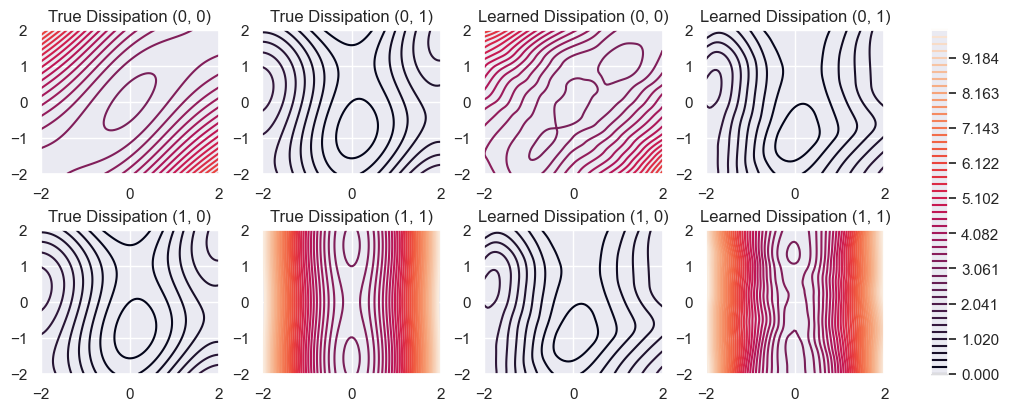

In [8]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
XY = np.stack([X, Y], axis=-1).reshape(-1, 2)
Z_true = jax.vmap(target_model.dissipation)(XY).reshape(100, 100, 2, 2)
Z_pred = jax.vmap(model.shared()[0])(XY).reshape(100, 100, 2, 2)
fig, ax = plt.subplots(2, 4, figsize=(10, 4), layout="constrained")
levels = np.linspace(0, 10, 50)

for i in range(2):
    for j in range(2):
        ct1 = ax[i, j].contour(X, Y, Z_true[:, :, i, j], levels=levels)
        ax[i, j].set_title(f"True Dissipation {i, j}")

        ct2 = ax[i, 2+j].contour(X, Y, Z_pred[:, :, i, j], levels=levels)
        ax[i, 2+j].set_title(f"Learned Dissipation {i, j}")

cbar = fig.colorbar(ct1, ax=ax)
# fig.savefig("test_case_dissiptation.pdf")